# Step 5 - Ukrainian-to-English translation with Transformer

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
def show_percentage(m, n):
    clear_output(wait=True)
    k = m / (n - 1)
    percent = int(k * 100)
    print('[' + 'x'*percent + '-'*(100 - percent) + ']' + " {:.2%}".format(k))
    print("{}/{} complete".format(m + 1, n))

### Parsing the data

In [ ]:
with open("/content/gdrive/MyDrive/practice_nlp_2022/data/ukr-eng/ukr.txt") as f:
    lines = f.read().split("\n")[:-1]
    
line1 = lines[25]
print(line1)

Do it.	Дій.	CC-BY 2.0 (France) Attribution: tatoeba.org #6049386 (mailohilohi) & #7555655 (miketheknight)


In [ ]:
text_pairs = []
n = len(lines)
for i in range(n):
    line = lines[i]
    eng, ukr = line.split("\t")[:2]
    ukr = "[start] " + ukr + " [end]"
    text_pairs.append((eng, ukr))
    show_percentage(i, n)

[xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx] 100.00%
154461/154461 complete


In [ ]:
with open("/content/gdrive/MyDrive/practice_nlp_2022/data/preprocessed_ukr.txt", "w") as new_f:
    for pair in text_pairs:
        eng, ukr = pair
        new_f.write(eng + " " + ukr + "\n")

##### Split the sentence pairs into a training set, a validation set, and a test set.

In [ ]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

154461 total pairs
108123 training pairs
23169 validation pairs
23169 test pairs


### Vectorizing the text data

##### We'll use two instances of the TextVectorization layer to vectorize the text data (one for English and one for Ukrainian), that is to say, to turn the original strings into integer sequences where each integer represents the index of a word in a vocabulary.
##### The English layer will use the default string standardization (strip punctuation characters) and splitting scheme (split on whitespace), while the Ukrainian layer will use a custom standardization, where we add the character "¿" to the set of punctuation characters to be stripped.

In [ ]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size, 
    output_mode="int", 
    output_sequence_length=sequence_length,
)
ukr_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

train_eng_texts = [pair[0] for pair in train_pairs]
train_ukr_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
ukr_vectorization.adapt(train_ukr_texts)

##### Next, we'll format our datasets. At each training step, the model will seek to predict target words N+1 (and beyond) using the source sentence and the target words 0 to N.

In [ ]:
# As such, the training dataset will yield a tuple (inputs, targets), where:
#    - inputs is a dictionary with the keys encoder_inputs and decoder_inputs. 
#      encoder_inputs is the vectorized source sentence and encoder_inputs is the 
#      target sentence "so far", that is to say, the words 0 to N used to predict 
#      word N+1 (and beyond) in the target sentence.
#    - target is the target sentence offset by one step: it provides the next 
#      words in the target sentence - what the model will try to predict.


def format_dataset(eng, ukr):
    eng = eng_vectorization(eng)
    ukr = ukr_vectorization(ukr)
    return ({"encoder_inputs": eng, "decoder_inputs": ukr[:, :-1],}, ukr[:, 1:])

def make_dataset(pairs):
    eng_texts, ukr_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    ukr_texts = list(ukr_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, ukr_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
# Let's take a quick look at the sequence shapes 
# (we have batches of 64 pairs, and all sequences are 20 steps long)

for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


### Building the model

In [ ]:
# Our sequence-to-sequence Transformer consists of a TransformerEncoder and a TransformerDecoder 
# chained together. To make the model aware of word order, we also use a PositionalEmbedding layer.

# The source sequence will be pass to the TransformerEncoder, which will produce a new 
# representation of it. This new representation will then be passed to the TransformerDecoder, 
# together with the target sequence so far (target words 0 to N). The TransformerDecoder will then 
# seek to predict the next words in the target sequence (N+1 and beyond).

# A key detail that makes this possible is causal masking (see method get_causal_attention_mask() 
# on the TransformerDecoder). The TransformerDecoder sees the entire sequences at once, and thus 
# we must make sure that it only uses information from target tokens 0 to N when predicting token N+1 
# (otherwise, it could use information from the future, which would result in a model that cannot be used at inference time).


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads
        })
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "latent_dim": self.latent_dim,
            "num_heads": self.num_heads
        })
        return config

In [ ]:
# Next, we assemble the end-to-end model.

embed_dim = 128
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(
    shape=(None,), 
    dtype="int64", 
    name="encoder_inputs"
)
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(
    shape=(None,), 
    dtype="int64", 
    name="decoder_inputs"
)
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], 
    decoder_outputs, 
    name="transformer"
)

### Training our model

In [ ]:
epochs = 17

transformer.compile(
    optimizer = "adam", 
    loss = "sparse_categorical_crossentropy", 
    metrics = ["accuracy"]
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/17
1690/1690 [==============================] - 143s 83ms/step - loss: 1.1636 - accuracy: 0.5208 - val_loss: 0.7869 - val_accuracy: 0.6142
Epoch 2/17
1690/1690 [==============================] - 135s 80ms/step - loss: 0.7491 - accuracy: 0.6304 - val_loss: 0.5942 - val_accuracy: 0.6754
Epoch 3/17
1690/1690 [==============================] - 135s 80ms/step - loss: 0.5857 - accuracy: 0.6788 - val_loss: 0.5139 - val_accuracy: 0.7012
Epoch 4/17
1690/1690 [==============================] - 135s 80ms/step - loss: 0.4920 - accuracy: 0.7097 - val_loss: 0.4760 - val_accuracy: 0.7162
Epoch 5/17
1690/1690 [==============================] - 135s 80ms/step - loss: 0.4313 - accuracy: 0.7315 - val_loss: 0.4544 - val_accuracy: 0.7268
Epoch 6/17
1690/1690 [==============================] - 135s 80ms/step - loss: 0.3880 - accuracy: 0.7475 - val_loss: 0.4456 - val_accuracy: 0.7325
Epoch 7/17
1690/1690 [==============================] - 135s 80ms/step - loss: 0.3555 - accuracy: 0.7617 - val_loss: 0

In [ ]:
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding_4 (Positi  (None, None, 128)   1922560     ['encoder_inputs[0][0]']         
 onalEmbedding)                                                                                   
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder_2 (Transfo  (None, None, 128)   1054464     ['positional_embedding_

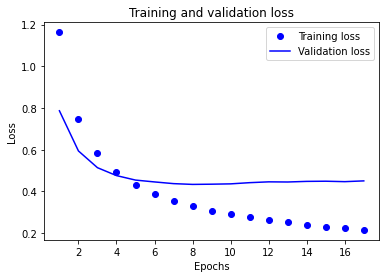

In [ ]:
history_dict = transformer.history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Decoding test sentences

In [ ]:
# Finally, let's demonstrate how to translate. We simply 
# feed into the model the vectorized English sentence as well as the target token "[start]", 
# then we repeatedly generated the next token, until we hit the token "[end]".

ukr_vocab = ukr_vectorization.get_vocabulary()
ukr_index_lookup = dict(zip(range(len(ukr_vocab)), ukr_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = ukr_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = ukr_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    print(input_sentence + " - " + translated)

I want to go on a trip with you. - [start] Я хочу піти в поїздку з тобою [end]
He got a bad reputation. - [start] Він має поганий найкраща подруга [end]
I don't think Tom can help us now. - [start] Не думаю що Том може нам зараз допомогти [end]
What's your beef? - [start] Яка у тебе яловичина [end]
Open the door, please. - [start] Двері відчиняються будь ласка [end]
I'll show you a few photos. - [start] Я покажу вам кілька фотографій [end]
I have a friend who works for NASA. - [start] У мене є подруга на рік [UNK] [end]
Tom felt a sharp pain in his stomach. - [start] Том почувався [UNK] під час живіт [end]
We all looked out the window. - [start] Ми всі [UNK] до вікна [end]
Tom said it was just a prank. - [start] Том сказав що це був прикол [end]
May I borrow your car? - [start] Можна я скористаюся вашою машиною [end]
I will give you a bicycle for your birthday. - [start] Я подарую вам велосипед на день народження [end]
Was there enough money? - [start] Грошей було достатньо [end]
A cup

### Save the model

In [ ]:
keras_model_path = "content/gdrive/MyDrive/practice_nlp_2022/data/ukr_eng_dir"
transformer.save(keras_model_path)

INFO:tensorflow:Assets written to: content/gdrive/MyDrive/practice_nlp_2022/data/ukr_eng_dir/assets


INFO:tensorflow:Assets written to: content/gdrive/MyDrive/practice_nlp_2022/data/ukr_eng_dir/assets


In [ ]:
restored_keras_model = tf.keras.models.load_model(keras_model_path)

ValueError: ignored